<a href="https://colab.research.google.com/github/kkostromin/sber_ds/blob/main/CV_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

С помощью CNN решить задачу множественной классификации изображений, в качестве данных использовать датасет CIFAR-10. Добиться точности классификации на тестовой выборке не менее 80% (для полного балла за ДЗ). Провести анализ ошибок - вычислить и построить гистограммы precision и recall для каждого класса, построить графики зависимости ошибок и точности тестовой и обучающей выборок в зависимости от эпох обучения.

**В ДЗ можно пользоваться кодом из лекции**

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torch.nn.functional as func 
from collections import defaultdict
import time
from torchsummary import summary
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import torchvision
from torchvision import transforms


In [2]:
# device_num = 0
# device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

# print(f"Device: {device}")

Device: cpu


In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device_num = 0
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

CUDA is available!  Training on GPU ...
Device: cuda:0


In [5]:
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 35.1 MB/s 
time: 491 µs (started: 2022-12-13 18:08:40 +00:00)


In [4]:
!nvidia-smi

Mon Dec 12 18:48:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

2) **Загрузите датасет и разбейте его на train и test**

In [6]:
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transforms.ToTensor()
)
# разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [40000, 10000]
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transforms.ToTensor()
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
time: 18.8 s (started: 2022-12-13 18:08:50 +00:00)


# Prepare data

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_dataset = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_dataset = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_batch_gen = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size,
    sampler=train_sampler, num_workers=num_workers)
val_batch_gen = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
time: 2.35 s (started: 2022-12-13 18:09:08 +00:00)


In [28]:
len(train_idx), len(test_dataset), len(valid_idx)

(40000, 10000, 10000)

In [29]:
#Обратите внимание что теперь 10 уникальных классов (не 2 как в лекции)
print(np.unique(dataset.targets))

[0 1 2 3 4 5 6 7 8 9]


In [30]:
#Размер всего датасета
print(dataset.data.shape)

(50000, 32, 32, 3)


In [8]:
input_size = 28 * 28
num_classes = 10
dropout_rate = 0.1

time: 624 µs (started: 2022-12-13 18:09:19 +00:00)


In [ ]:
# batch_size = 30

# train_batch_gen = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True
# )
# val_batch_gen = torch.utils.data.DataLoader(
#     test_dataset, batch_size=batch_size, shuffle=True
# )
# test_batch_gen = torch.utils.data.DataLoader(
#     test_dataset, batch_size=batch_size, shuffle=False
# )

In [32]:
len(train_dataset), len(test_dataset), len(val_dataset)

(50000, 10000, 10000)

# Create Net Class

In [47]:
class Net(nn.Module):
   
    def __init__(self):
        
        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.05),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x



time: 4.04 ms (started: 2022-12-13 19:40:27 +00:00)


#Criterion & optimizer

In [48]:
model = Net()

print(model)


if train_on_gpu:
    model.cuda()

criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.1, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

#Plot func

In [11]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

time: 1.58 ms (started: 2022-12-13 18:09:41 +00:00)


#Train func 1

In [11]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=20
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        # start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            if train_on_gpu:
               X_batch = X_batch.cuda()
               y_batch = y_batch.cuda()
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            if train_on_gpu:
              X_batch = X_batch.cuda()
              y_batch = y_batch.cuda()
            
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
       
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

time: 6.51 ms (started: 2022-12-12 16:27:51 +00:00)


#Train func 2

In [37]:
def train_2(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs = 30
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    val_loss_min = np.Inf # track change in validation loss

    history = defaultdict(lambda: defaultdict(list))
    
   
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()


        ###################
        # train the model #
        ###################

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            if train_on_gpu:
               X_batch = X_batch.cuda()
               y_batch = y_batch.cuda()
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        # Устанавливаем поведение dropout / batch_norm  в обучение

        # model.train(True) 
        
        # for data, target in train_batch_gen:
        # # move tensors to GPU if CUDA is available
        #       if train_on_gpu:
        #           data, target = data.cuda(), target.cuda()
        #       # clear the gradients of all optimized variables
        #       optimizer.zero_grad()
        #       # forward pass: compute predicted outputs by passing inputs to the model
        #       output = model(data)
        #       # calculate the batch loss
        #       loss = criterion(output, target)
        #       # backward pass: compute gradient of the loss with respect to model parameters
        #       loss.backward()
        #       # perform a single optimization step (parameter update)
        #       optimizer.step()
        #       # update training loss
        #       train_loss += loss.item()*data.size(0)
             
              
        # print("######### TEST ##############")


        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        ######################    
        # validate the model #
        ######################
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            if train_on_gpu:
              X_batch = X_batch.cuda()
              y_batch = y_batch.cuda()
            
            with torch.no_grad():
                logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # # Устанавливаем поведение dropout / batch_norm в режим тестирования
        #  model.train(False)

        # for data, target in val_batch_gen:
        #       # move tensors to GPU if CUDA is available
        #       if train_on_gpu:
        #           data, target = data.cuda(), target.cuda()
        #       # forward pass: compute predicted outputs by passing inputs to the model
        #       output = model(data)
        #       # calculate the batch loss
        #       loss = criterion(output, target)
        #       # update average validation loss 
        #       val_loss += loss.item()*data.size(0)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)


        #clear_output()


        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, val_loss))
        print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy {:.6f}'.format(
        epoch, train_acc * 100, val_acc * 100))
      

        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          val_loss_min,
          val_loss))
          torch.save(model.state_dict(), 'model_cifar2.pt')
          val_loss_min = val_loss
     
      
        # # Печатаем результаты после каждой эпохи
        # print("Epoch {} of {} took {:.3f}s".format(
        #     epoch + 1, num_epochs, time.time() - start_time))
        # print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        # print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        # print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        # print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        #plot_learning_curves(history)

        #clear_output()
        
    return model, history

time: 4.29 ms (started: 2022-12-13 19:16:31 +00:00)


#Run model

In [49]:
model, history = train_2(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs = 10
)

Epoch: 0 	Training Loss: 1.539541 	Validation Loss: 1.197517
Epoch: 0 	Training accuracy: 42.782500 	Validation accuracy 56.610000
Validation loss decreased (inf --> 1.197517).  Saving model ...
Epoch: 1 	Training Loss: 1.004667 	Validation Loss: 0.906630
Epoch: 1 	Training accuracy: 63.910000 	Validation accuracy 68.610000
Validation loss decreased (1.197517 --> 0.906630).  Saving model ...
Epoch: 2 	Training Loss: 0.772466 	Validation Loss: 0.786335
Epoch: 2 	Training accuracy: 72.837500 	Validation accuracy 72.640000
Validation loss decreased (0.906630 --> 0.786335).  Saving model ...
Epoch: 3 	Training Loss: 0.642076 	Validation Loss: 0.683783
Epoch: 3 	Training accuracy: 77.395000 	Validation accuracy 76.100000
Validation loss decreased (0.786335 --> 0.683783).  Saving model ...
Epoch: 4 	Training Loss: 0.542173 	Validation Loss: 0.671754
Epoch: 4 	Training accuracy: 81.100000 	Validation accuracy 76.670000
Validation loss decreased (0.683783 --> 0.671754).  Saving model ...
Epoch

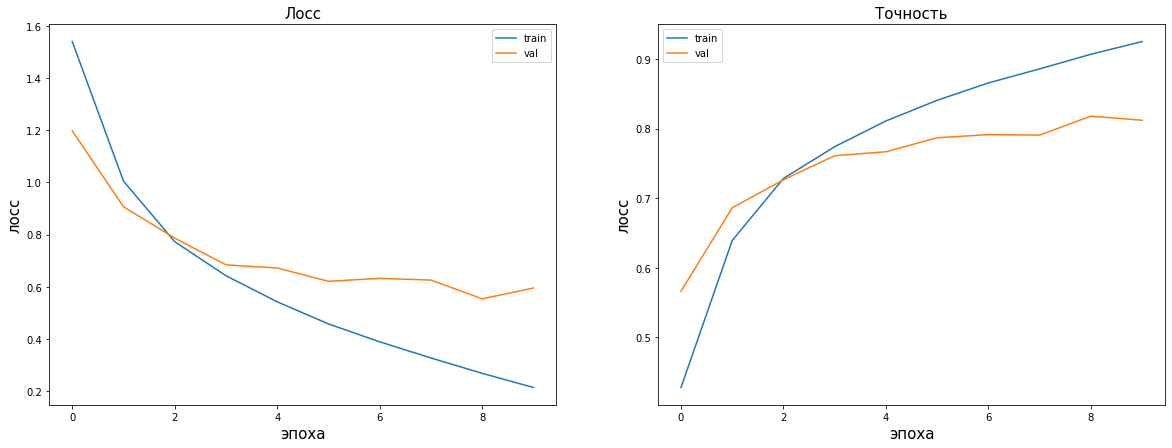

time: 282 ms (started: 2022-12-13 19:49:07 +00:00)


In [50]:
plot_learning_curves(history)

In [51]:
model.load_state_dict(torch.load('model_cifar2.pt'))

<All keys matched successfully>

time: 24.4 ms (started: 2022-12-13 19:49:12 +00:00)


вычислить и построить гистограммы precision и recall для каждого класса

# Plot Accuracy for class

In [52]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10)) # TP
class_tn = list(0. for i in range(10)) # TN
class_fp = list(0. for i in range(10)) # FP 
class_fn = list(0. for i in range(10)) # FN
class_total = list(0. for i in range(10))
 
model.eval()
# iterate over test data
for data, target in test_batch_gen:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
     data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
   
    # compare predictions to true label 
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()) 
 

    # compare predictions to false label   
    neg_tensor = pred.ne(target.data.view_as(pred))
    ncorrect = np.squeeze(neg_tensor.numpy()) if not train_on_gpu else np.squeeze(neg_tensor.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        
        class_correct[label] += correct[i].item()
        # print(class_correct[label])
        class_total[label] += 1

        #fp
   
# print(class_total)
# print(class_correct)
    
# average test loss
test_loss = test_loss/len(test_batch_gen.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total [i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
       # print(class_correct[i])
        #print('Test Presition of %5s: %2d%%' % (
         #  classes[i], ))

    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Print the precision and recall, among other metrics
#print(metrics.classification_report(y_true, y_pred, digits=3))    

Test Loss: 0.548449

Test Accuracy of airplane: 86% (868/1000)
Test Accuracy of automobile: 90% (901/1000)
Test Accuracy of  bird: 71% (712/1000)
Test Accuracy of   cat: 69% (699/1000)
Test Accuracy of  deer: 80% (802/1000)
Test Accuracy of   dog: 69% (690/1000)
Test Accuracy of  frog: 88% (887/1000)
Test Accuracy of horse: 87% (871/1000)
Test Accuracy of  ship: 90% (900/1000)
Test Accuracy of truck: 88% (882/1000)

Test Accuracy (Overall): 82% (8212/10000)
time: 3.89 s (started: 2022-12-13 19:49:14 +00:00)


#Grafics

*batch_size = 20 : *
Epoch 16 of 30 took 20.734s
  training loss (in-iteration): 	0.532710
  validation loss (in-iteration): 	0.710816
  training accuracy: 			81.31 %
  validation accuracy: 			75.51 %

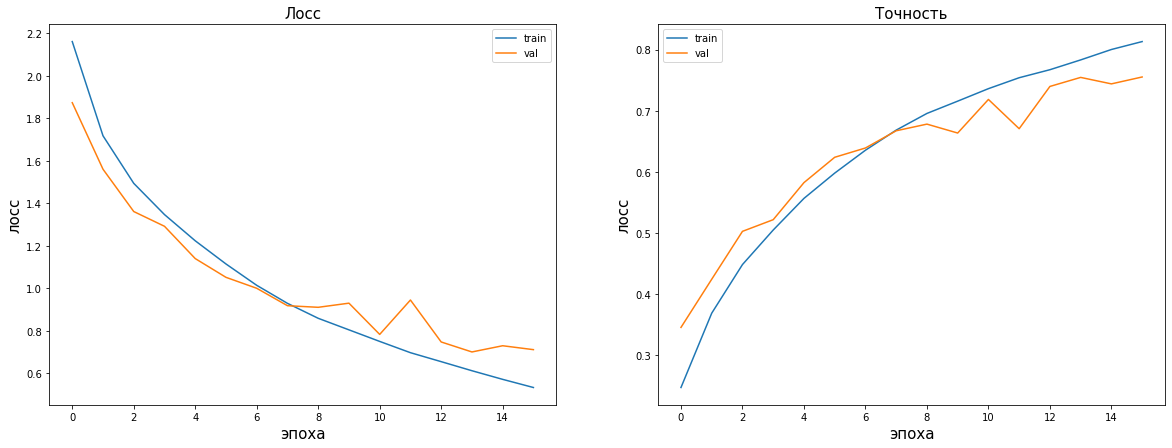

*batch_size = 20, 
valid_size = 0.3
 
 -> Epoch 17 of 30 took 17.371s
 
  training loss (in-iteration): 	0.551647
 
  validation loss (in-iteration): 	0.728188
 
  training accuracy: 			80.62 %
 
  validation accuracy: 			75.05 %

  
  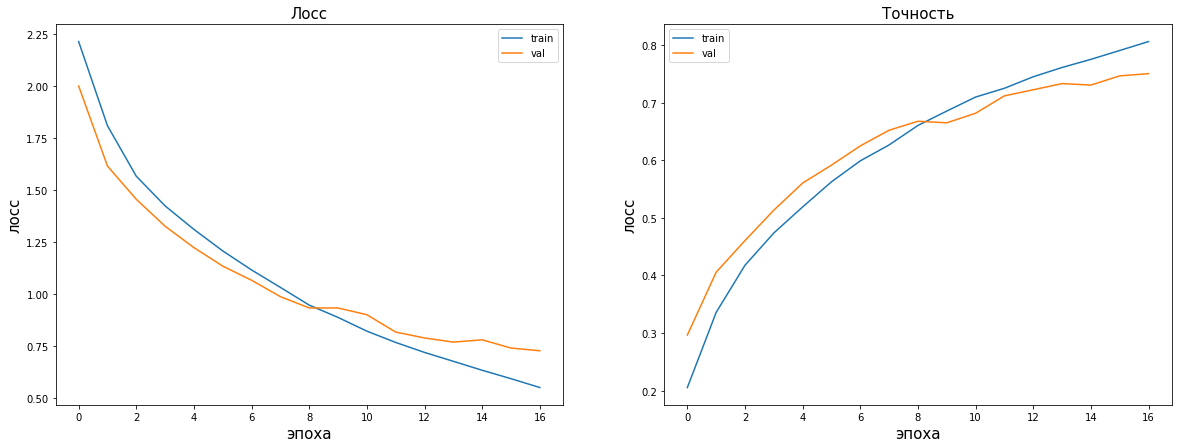

*batch_size = 30
valid_size = 0.2
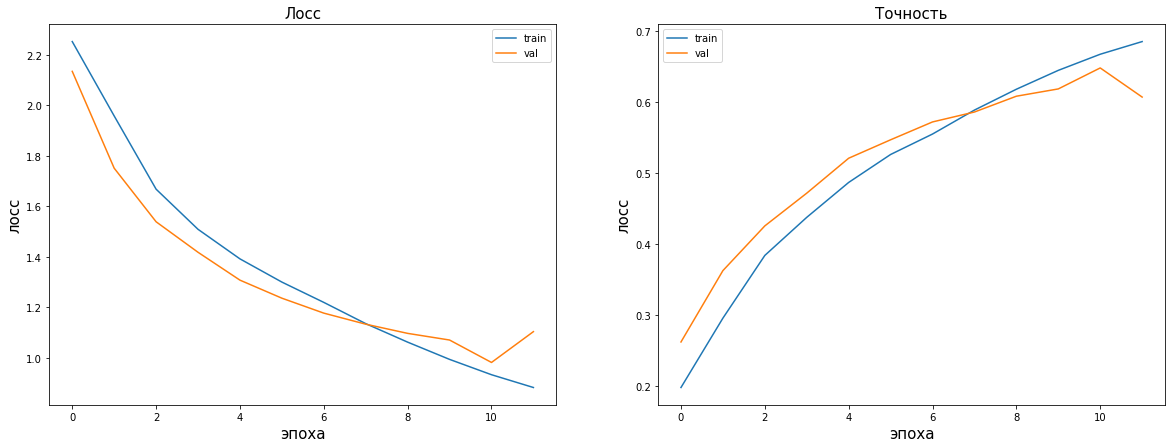


normolise: 

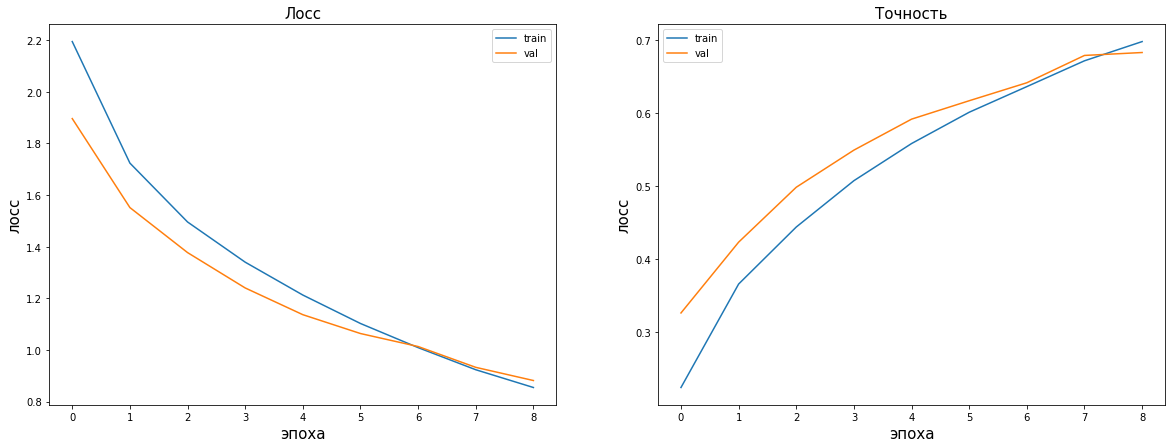

dropout: p=0,05

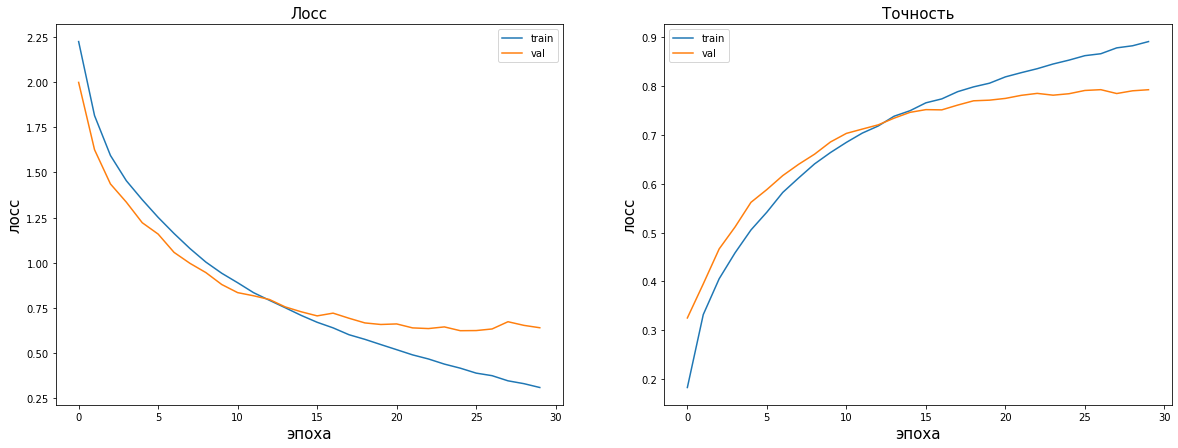


dropout p = 0.1

lr = 0.001


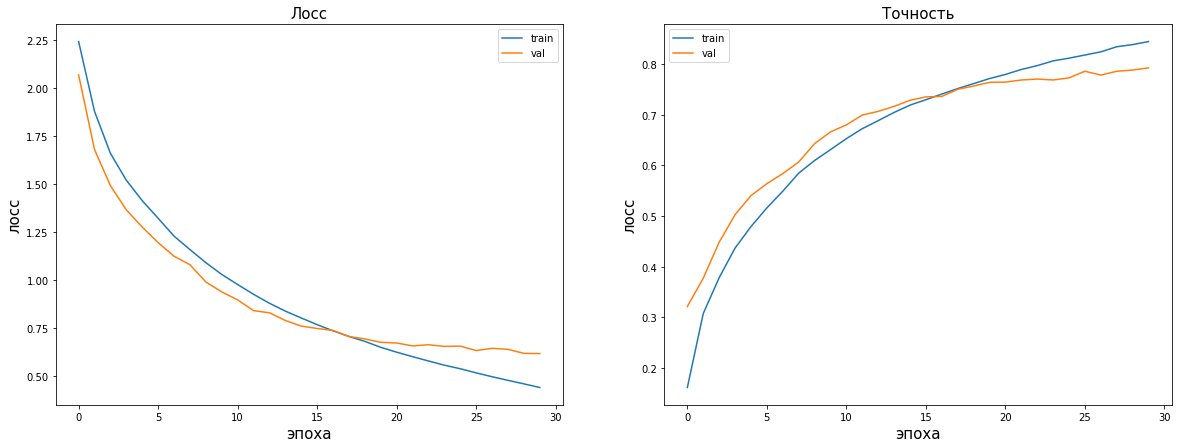

dropout p = 0.2
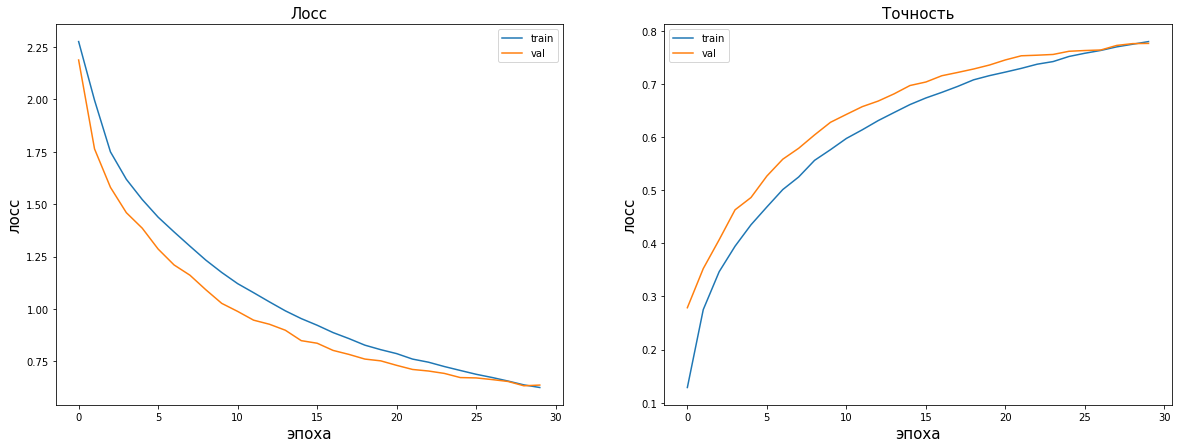

dropuot p = 0.3 

lr = 0.001

Epoch 30 of 30 took 29.826s: 
  training loss (in-iteration): 	0.879358
  
  validation loss (in-iteration): 	0.779119
  
  training accuracy: 			68.97 %
  
  validation accuracy: 			72.47 %

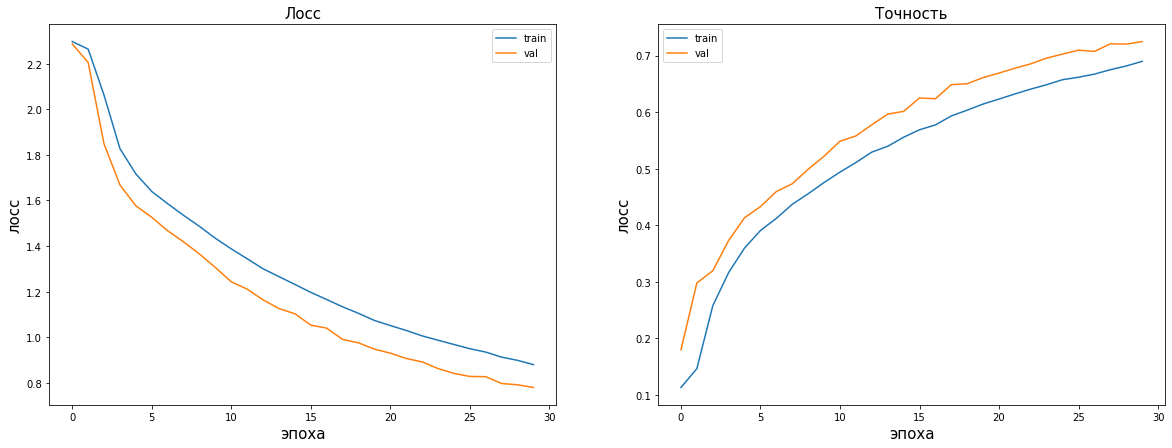

dropuot p = 0.2

lr = 0.001

Test Accuracy (Overall): 82% (8278/10000)
time: 4.05 s (started: 2022-12-13 18:27:28 +00:00)

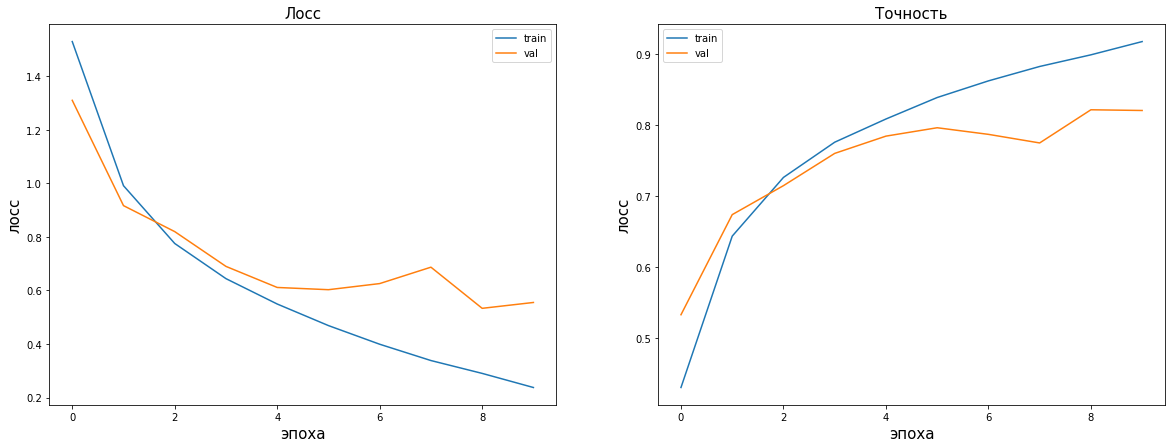

dropuot p = 0.2

lr = 0.001

Test Accuracy (Overall): 82% (8219/10000)
time: 5.62 s (started: 2022-12-13 18:59:42 +00:00)

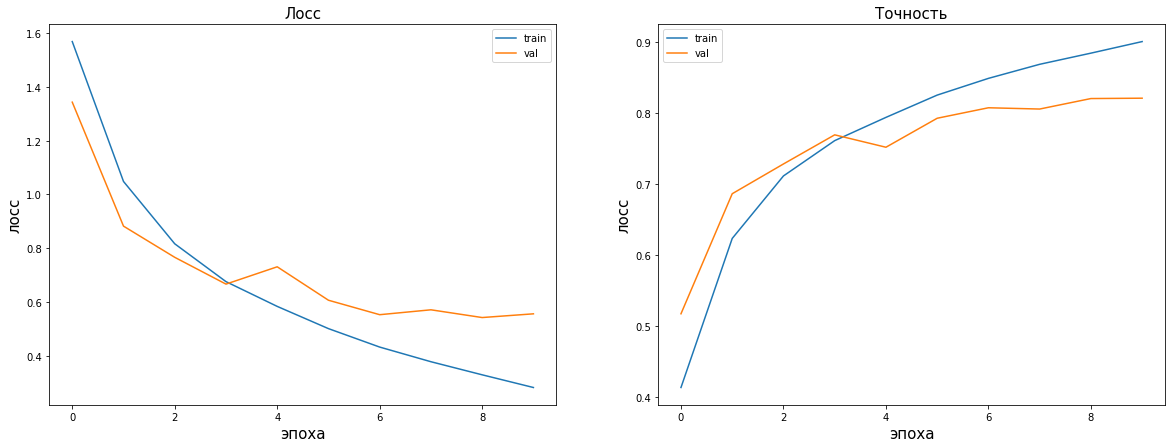

dropuot p = 0.3

Test Accuracy (Overall): 81% (8191/10000)


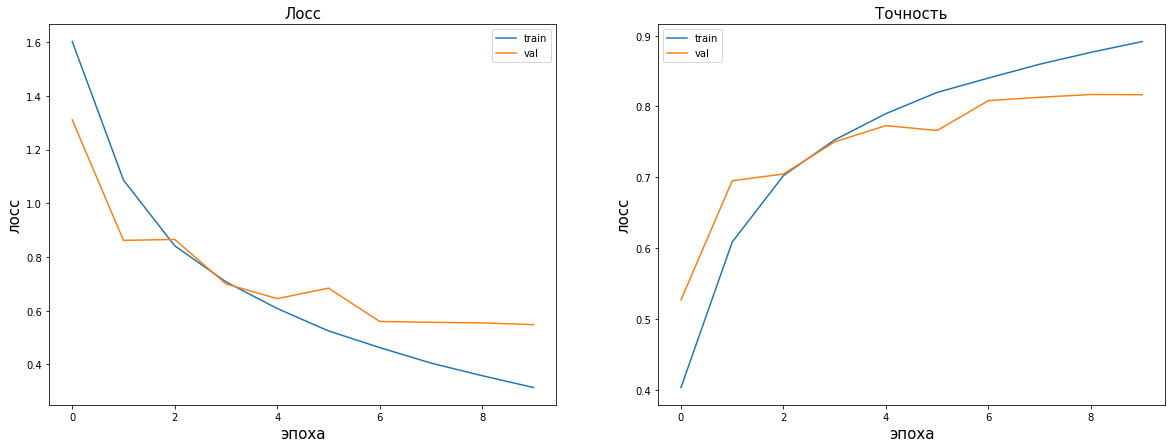

lr = 0.005

Test Accuracy (Overall): 80% (8047/10000)
time: 3.96 s (started: 2022-12-13 19:24:01 +00:00)

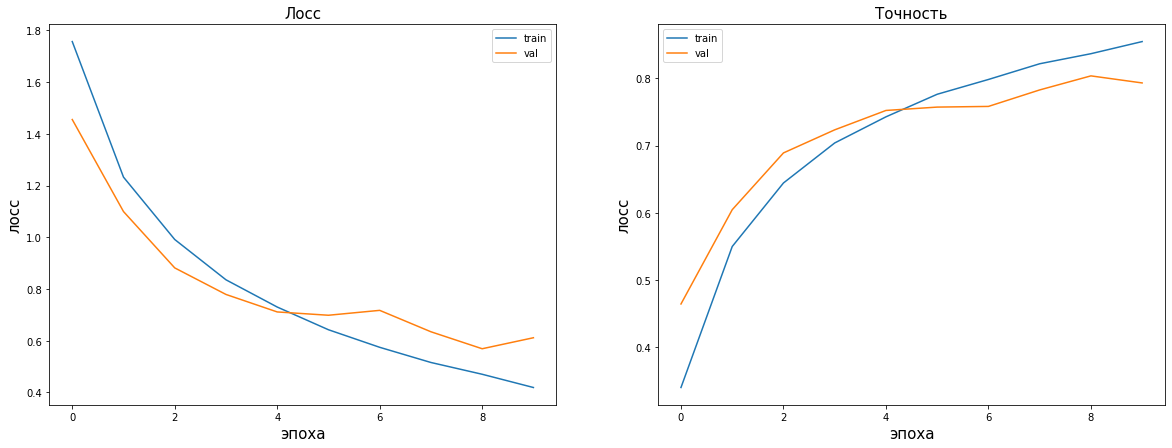

4) **Построите графики обучения и проанализируйте ошибки сети, сделайте выводы**

In [ ]:
# your code here

# Hint: графики необходимы для того, чтобы следить за тем, не переобучилась ли модель
# в случае переобучения можно попробовать изменить размер сети, добавить слои batchnorm и dropout